In [1]:
# Importing necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading csv file in the form of dataframe
stroke=pd.read_csv("healthcare-dataset-stroke-data-version-3.csv")
stroke.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,age_group,BMI_class,glucose_class,work_type_Govt_job,...,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,gender_Female,gender_Male,ever_married_No,ever_married_Yes,Residence_type_Rural,Residence_type_Urban
0,67.0,0,1,228.69,36.6,1,4,1,0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,61.0,0,0,202.21,28.1,1,4,3,0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,80.0,0,1,105.92,32.5,1,4,1,2,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,49.0,0,0,171.23,34.4,1,3,1,0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
4,79.0,1,0,174.12,24.0,1,4,0,0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


# Data Split - 70:30 Ratio

In [3]:
from sklearn.model_selection import train_test_split

# input features
X = stroke.drop(['stroke'], axis=1)

# Output Label
y = stroke['stroke']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69, stratify=y)


print("X_train:", X_train.shape)
print("X_test:",X_test.shape)
print("y_train: \n",y_train.value_counts())
print("y_test: \n",y_test.value_counts())

X_train: (3577, 22)
X_test: (1533, 22)
y_train: 
 stroke
0    3403
1     174
Name: count, dtype: int64
y_test: 
 stroke
0    1458
1      75
Name: count, dtype: int64


# Feature Selection

[ True  True False  True  True  True  True False False False  True False
 False False  True False  True False False False False  True]
[ 1  1  3  1  1  1  1  2 11 13  1  5 10  4  1  8  1  9 12  6  7  1]


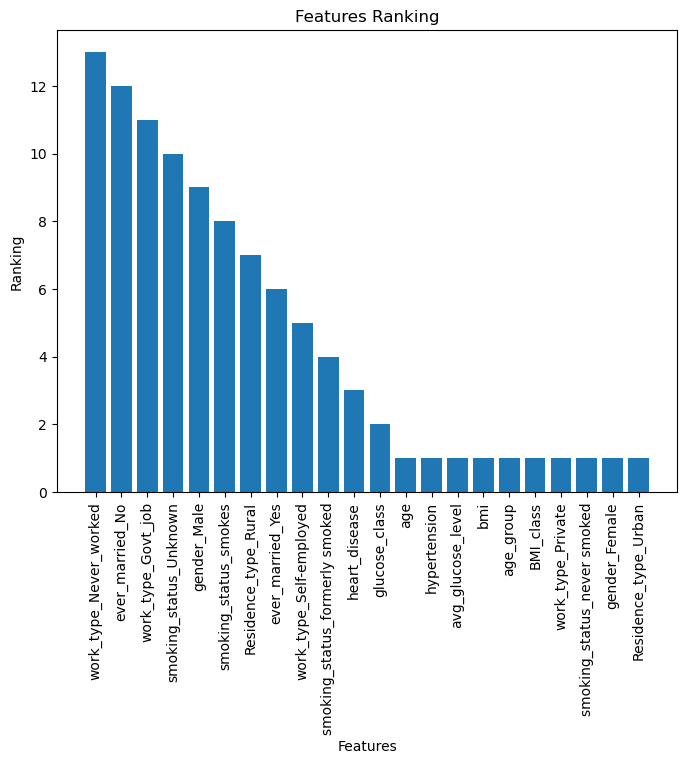

In [4]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# create Decision Tree object
rf = RandomForestClassifier(random_state=42)

# create RFE model and select top 10 features
rfe = RFE(rf, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

# sort the ranking in descending order
ranked_cols = sorted(zip(X_train.columns, rfe.ranking_), key=lambda x: x[1], reverse=True)

# visualize the selected features
plt.figure(figsize=(8,6))
plt.title("Features Ranking")
plt.xlabel("Features")
plt.ylabel("Ranking")
plt.bar(range(len(rfe.ranking_)), [ranked_col[1] for ranked_col in ranked_cols])
plt.xticks(range(len(rfe.ranking_)), [ranked_col[0] for ranked_col in ranked_cols], rotation=90)
plt.show()

In [5]:
# transform the data using the selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Data Scaling - Standardisation

In [6]:
# Putting the data into similar scale using the standardisation method

from sklearn.preprocessing import StandardScaler

# Instantiate the standard scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train_rfe)
X_test_scaled = scaler.transform(X_test_rfe)

# OverSampling the Train Data with SMOTE


    Synthetic Minority Over-sampling Technique (SMOTE) is a technique for oversampling imbalanced data by generating sythentic samples for the minority class.The obtained dataset will be used for training our ml models.
   

In [7]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Print the distribution of the original and resampled sets
print("Original set distribution: \n", y_train.value_counts())
print("\nResampled set distribution: \n", pd.Series(y_train_resampled).value_counts())


Original set distribution: 
 stroke
0    3403
1     174
Name: count, dtype: int64

Resampled set distribution: 
 stroke
0    3403
1    3403
Name: count, dtype: int64


    Now we will use this resampled data for training our various ml models

In [8]:
from sklearn.model_selection import cross_val_score, KFold, cross_validate, learning_curve
from sklearn.metrics import auc, roc_auc_score, confusion_matrix, roc_curve, classification_report

# Create a function to display results of models
def display_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    
    print("Confusion Matrix:\n ")
    print(cm)
    print('\n')
    print("Classification Report:\n ")
    print(cr)

# KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Range of K values to try
k_range = list(range(1, 31))

# Search for best K
param_grid = {'n_neighbors': k_range}
knn = KNeighborsClassifier()
kf = KFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(knn, param_grid, cv=kf)
grid_search.fit(X_train_resampled, y_train_resampled)

# Retrieve best K
best_k = grid_search.best_params_['n_neighbors']

# Display the results
print("Best k value: {}".format(best_k))

Best k value: 1


In [10]:
# Create a new KNN classifier with the best value
knn_best = KNeighborsClassifier(n_neighbors=1)

#Evaluate on KNN model train set
knn_best.fit(X_train_resampled, y_train_resampled)
y_pred = knn_best.predict(X_train_resampled)

# Display metrics
print("Train metrics")
display_metrics(y_train_resampled, y_pred)

Train metrics
Confusion Matrix:
 
[[3403    0]
 [   0 3403]]


Classification Report:
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3403
           1       1.00      1.00      1.00      3403

    accuracy                           1.00      6806
   macro avg       1.00      1.00      1.00      6806
weighted avg       1.00      1.00      1.00      6806



In [11]:
# Predict on the test set
y_pred = knn_best.predict(X_test_scaled)

# Display metrics
print("KNN Test metrics")
display_metrics(y_test, y_pred)

KNN Test metrics
Confusion Matrix:
 
[[1353  105]
 [  61   14]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1458
           1       0.12      0.19      0.14        75

    accuracy                           0.89      1533
   macro avg       0.54      0.56      0.54      1533
weighted avg       0.92      0.89      0.90      1533



# DECISION TREE

In [12]:
# Tuning the hyperparameters of the Decision Tree model to identify the best parameters.
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the Decision Tree classifier
dt = DecisionTreeClassifier()

# Define the hyperparameters and their values to test
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_dt = GridSearchCV(dt, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_dt.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_dt.best_params_)
print("Best score: ", grid_dt.best_score_)

Best hyperparameters:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score:  0.9337575186339908


In [13]:
# Create a new decision tree classifier with the best hyperparameters

dt_best = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, 
                             min_samples_split=2, criterion='entropy')

# Evaluate the DT model on the train set
dt_best.fit(X_train_resampled, y_train_resampled)
y_pred = dt_best.predict(X_train_resampled)

# Display metrics
print("Train metrics")
display_metrics(y_train_resampled, y_pred)

Train metrics
Confusion Matrix:
 
[[3403    0]
 [   0 3403]]


Classification Report:
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3403
           1       1.00      1.00      1.00      3403

    accuracy                           1.00      6806
   macro avg       1.00      1.00      1.00      6806
weighted avg       1.00      1.00      1.00      6806



In [14]:
# Predict on the test set
y_pred = dt_best.predict(X_test_scaled)

# Display metrics
print("Decision Tree Test metrics")
display_metrics(y_test, y_pred)

Decision Tree Test metrics
Confusion Matrix:
 
[[1347  111]
 [  56   19]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1458
           1       0.15      0.25      0.19        75

    accuracy                           0.89      1533
   macro avg       0.55      0.59      0.56      1533
weighted avg       0.92      0.89      0.90      1533



# RANDOM FOREST

In [15]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Tuning the hyperparameters for the best parameters
# Define the parameter grid to search over
param_grid = {'n_estimators': [50, 100],
              'max_depth': [None, 20],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2],
             'max_features': ['sqrt', 'log2'],
              'criterion': ['gini', 'entropy']}

# Create a random forest classifier
rfc = RandomForestClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and best score
print("Best hyperparameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 score: 0.967588420151742


In [16]:
# Create a Random Forest classifier with the best hyperparameters for cross-validation
rfc_best = RandomForestClassifier(criterion='entropy', max_depth=None, max_features='log2',
                              min_samples_split=2, n_estimators=100)

# Evaluate the RF model on the train set
rfc_best.fit(X_train_resampled, y_train_resampled)
y_pred = rfc_best.predict(X_train_resampled)


# Display metrics
print("Train Metrics")
display_metrics(y_train_resampled, y_pred)

Train Metrics
Confusion Matrix:
 
[[3403    0]
 [   0 3403]]


Classification Report:
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3403
           1       1.00      1.00      1.00      3403

    accuracy                           1.00      6806
   macro avg       1.00      1.00      1.00      6806
weighted avg       1.00      1.00      1.00      6806



In [17]:
# Predict on the test set
y_pred = rfc_best.predict(X_test_scaled)

# Display metrics
print("Random Forest Test metrics")
display_metrics(y_test, y_pred)

Random Forest Test metrics
Confusion Matrix:
 
[[1394   64]
 [  61   14]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1458
           1       0.18      0.19      0.18        75

    accuracy                           0.92      1533
   macro avg       0.57      0.57      0.57      1533
weighted avg       0.92      0.92      0.92      1533



# SVM

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Initialize SVM classifier
svm = SVC()

# Define a dictionary of hyperparameters to test
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Use GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)


Best hyperparameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


In [19]:
from sklearn.svm import SVC

# Create a new SVM classifier with the best hyperparameters
svm_best = SVC(C=grid_search.best_params_['C'], 
               kernel=grid_search.best_params_['kernel'], 
               gamma=grid_search.best_params_['gamma'])

# Fit the SVM model on the training data
svm_best.fit(X_train_resampled, y_train_resampled)

# Predict on the training data
y_pred_train = svm_best.predict(X_train_resampled)

# Display metrics for training set
print("Train metrics")
display_metrics(y_train_resampled, y_pred_train)


Train metrics
Confusion Matrix:
 
[[3184  219]
 [  21 3382]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      3403
           1       0.94      0.99      0.97      3403

    accuracy                           0.96      6806
   macro avg       0.97      0.96      0.96      6806
weighted avg       0.97      0.96      0.96      6806



In [20]:
# Predict on the test set using the SVM model
y_pred_test = svm_best.predict(X_test_scaled)

# Display metrics for the test set
print("SVM Test metrics")
display_metrics(y_test, y_pred_test)


SVM Test metrics
Confusion Matrix:
 
[[1312  146]
 [  60   15]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1458
           1       0.09      0.20      0.13        75

    accuracy                           0.87      1533
   macro avg       0.52      0.55      0.53      1533
weighted avg       0.91      0.87      0.89      1533



# NAIVE BAIYES

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# Create a new Gaussian Naive Bayes classifier
naive_bayes_best = GaussianNB()

# Evaluate the Naive Bayes model on the training set
naive_bayes_best.fit(X_train_resampled, y_train_resampled)
y_pred = naive_bayes_best.predict(X_train_resampled)

# Display metrics
print("Train metrics:")
print(classification_report(y_train_resampled, y_pred))


Train metrics:
              precision    recall  f1-score   support

           0       0.90      0.66      0.76      3403
           1       0.73      0.92      0.81      3403

    accuracy                           0.79      6806
   macro avg       0.81      0.79      0.79      6806
weighted avg       0.81      0.79      0.79      6806



In [22]:
# Predict on the test set
y_pred = naive_bayes_best.predict(X_test_scaled)

# Display metrics
print("Test metrics")
display_metrics(y_test, y_pred)

Test metrics
Confusion Matrix:
 
[[930 528]
 [  8  67]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.99      0.64      0.78      1458
           1       0.11      0.89      0.20        75

    accuracy                           0.65      1533
   macro avg       0.55      0.77      0.49      1533
weighted avg       0.95      0.65      0.75      1533



# PERCEPTRON

In [23]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report

# Create a new Perceptron classifier
perceptron_model = Perceptron()

# Evaluate the Perceptron model on the training set
perceptron_model.fit(X_train_resampled, y_train_resampled)
y_pred = perceptron_model.predict(X_train_resampled)

# Display metrics
print("Train metrics:")
print(classification_report(y_train_resampled, y_pred))


Train metrics:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      3403
           1       0.76      0.68      0.72      3403

    accuracy                           0.74      6806
   macro avg       0.74      0.74      0.74      6806
weighted avg       0.74      0.74      0.74      6806



In [24]:
# Predict on the test set
y_pred = perceptron_model.predict(X_test_scaled)

# Display metrics
print("Test metrics")
display_metrics(y_test, y_pred)

Test metrics
Confusion Matrix:
 
[[1151  307]
 [  25   50]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      1458
           1       0.14      0.67      0.23        75

    accuracy                           0.78      1533
   macro avg       0.56      0.73      0.55      1533
weighted avg       0.94      0.78      0.84      1533



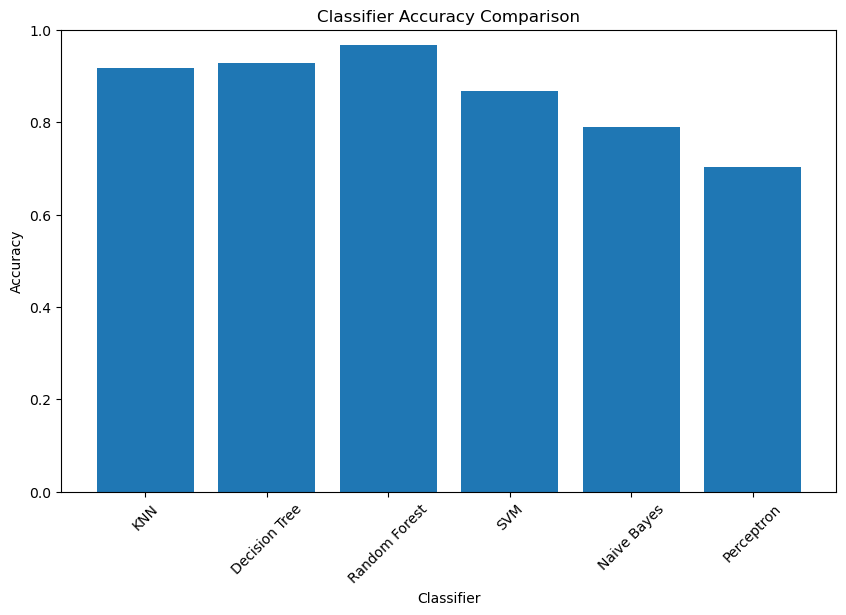

In [25]:
# Define classifiers
classifiers = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Naive Bayes': GaussianNB(),
    'Perceptron': Perceptron()
}

# Calculate cross-validation accuracy for each classifier
results = {}
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train_resampled, y_train_resampled)
    results[name] = scores.mean()

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(range(len(results)), list(results.values()), align='center')
plt.xticks(range(len(results)), list(results.keys()), rotation=45)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy Comparison')
plt.ylim([0, 1])
plt.show()

Observations

    Random Forest has shown the best performance among the used ml models.

# Evaluation of different models

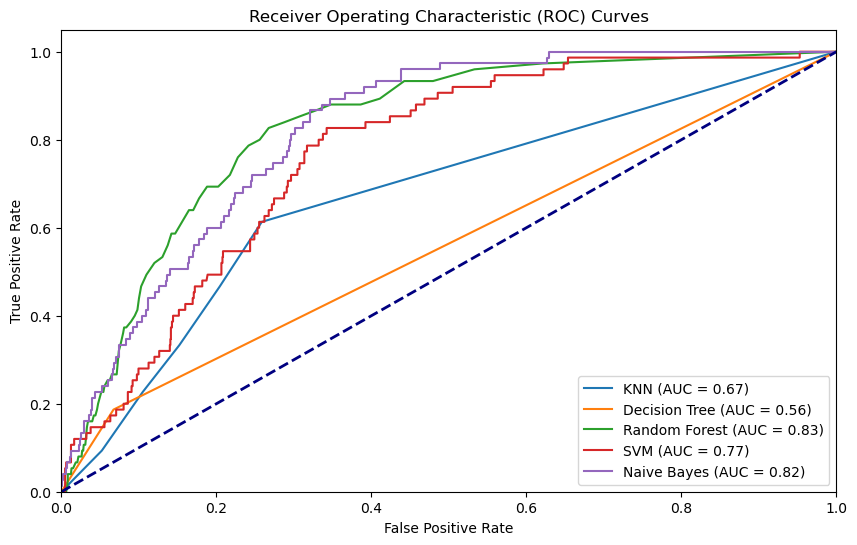

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define classifiers
classifiers = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB()
}

# Plot ROC curves for each classifier
plt.figure(figsize=(10, 6))
for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    y_score = clf.predict_proba(X_test_scaled)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (name, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


# Evaluating Our Best Model (Random Forest)

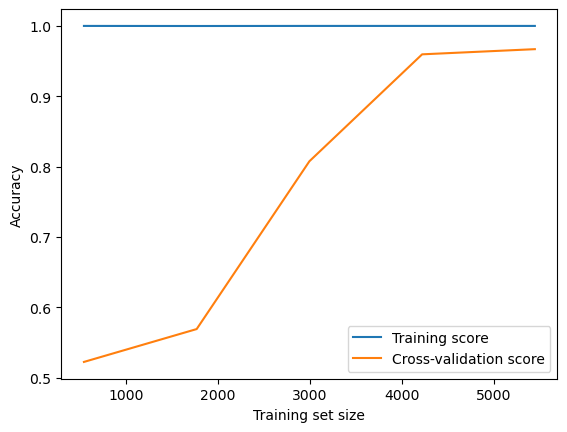

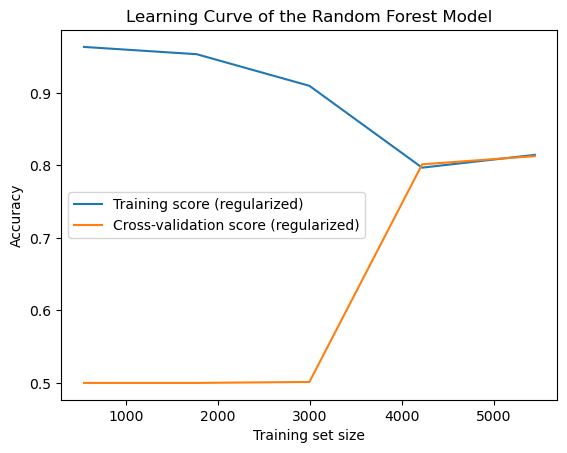

In [27]:
""" Monitoring the learning curve of the Random Forest Model"""

# Train the classifier
rfc_best.fit(X_train_resampled, y_train_resampled)

# Step 4: Monitor learning curves
train_sizes, train_scores, test_scores = learning_curve(rfc_best, X_train_resampled, y_train_resampled, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Step 5: Apply regularization (in this case, limit the depth of the trees)
clf_regularized = RandomForestClassifier(max_depth=3, random_state=42)
clf_regularized.fit(X_train_resampled, y_train_resampled)

# Check the performance of the regularized model
train_sizes_reg, train_scores_reg, test_scores_reg = learning_curve(clf_regularized, X_train_resampled, y_train_resampled, cv=5)

train_scores_mean_reg = np.mean(train_scores_reg, axis=1)
test_scores_mean_reg = np.mean(test_scores_reg, axis=1)

plt.plot(train_sizes_reg, train_scores_mean_reg, label='Training score (regularized)')
plt.plot(train_sizes_reg, test_scores_mean_reg, label='Cross-validation score (regularized)')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve of the Random Forest Model')
plt.legend()
plt.show()

    Observation: The model is overfitting on the train data and the cross-validation score increases as the training size increases which is a good sign that the model is generalizing well to new data. The training score decreasing as the training size increases is expected because of the regularization, and the increasing cross-validation score indicates in its ability to generalize to new data.